In [ ]:
# default_exp instance_segmentation.model

In [ ]:
#hide

%load_ext autoreload
%autoreload 2

# Model

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color. 

In [ ]:
# export

from pathlib import Path
from typing import List, Tuple, Union, Optional, Dict, Set

In [ ]:
# exporti

import numpy as np
import pandas as pd
from datetime import datetime
import PIL
from PIL import Image
from zipfile import ZipFile
import random
import math

import torch
import torch.utils.data
from torch.hub import download_url_to_file

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage

from dolphins_recognition_challenge.datasets import stack_imgs
from dolphins_recognition_challenge import utils

from dolphins_recognition_challenge.datasets import get_dataset

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
#hide

import seaborn as sns

In [ ]:
#hide

for m in [np, torch, torchvision, PIL]:
    print(f"{m.__name__:12}: {m.__version__}")

numpy       : 1.18.5
torch       : 1.7.0
torchvision : 0.8.1
PIL         : 7.2.0


In [ ]:
#hide
import pandas as pd
import seaborn as sns

## Model

Here is an example of how to create a model for instance segmentation:

In [ ]:
def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True,
        box_score_thresh=box_score_thresh,
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

In [ ]:

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
#export

def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    print_freq=10,
):
    """ Trains one epoch of the model. Copied from the reference implementation from https://github.com/pytorch/vision.git.
    """
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


For training the model, you can use `train_one_epoch` as follows:

In [ ]:
#hide

from dolphins_recognition_challenge.datasets import ToTensor, RandomHorizontalFlip, Compose

class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target
    
def get_my_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
        transforms.append(MyColorJitter())
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

This is how to use the training function in training loop:

In [ ]:
# hide 

# this one is run in make test and here we only train for one epoch

num_epochs = 1

data_loader, data_loader_test = get_dataset("segmentation", batch_size=4, get_tensor_transforms=get_my_tensor_transforms, n_samples=2)

In [ ]:
# skip

if Path("saved_models").exists():
    saved_model_path = Path("./saved_models/model.pt")
else:
    saved_model_path = Path("./notebooks/saved_models/model.pt")
    
if saved_model_path.exists():
    num_epochs=1
else:
    num_epochs = 20

data_loader, data_loader_test = get_dataset("segmentation", batch_size=4, get_tensor_transforms=get_my_tensor_transforms)

In [ ]:
# hide_output

for epoch in range(num_epochs):
    # train for one epoch, printing every 20 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=20)
    
    # update the learning rate
    lr_scheduler.step()

/root/.local/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:01:22  lr: 0.000133  loss: 6.7874 (6.7874)  loss_classifier: 0.8019 (0.8019)  loss_box_reg: 0.2460 (0.2460)  loss_mask: 5.7297 (5.7297)  loss_objectness: 0.0029 (0.0029)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 2.0719  data: 1.2201  max mem: 4474
Epoch: [0]  [20/40]  eta: 0:00:15  lr: 0.002695  loss: 1.1953 (1.8630)  loss_classifier: 0.2381 (0.3160)  loss_box_reg: 0.2601 (0.2670)  loss_mask: 0.5565 (1.2074)  loss_objectness: 0.0194 (0.0407)  loss_rpn_box_reg: 0.0134 (0.0319)  time: 0.6907  data: 0.0109  max mem: 5183
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6411 (1.3123)  loss_classifier: 0.1061 (0.2195)  loss_box_reg: 0.2015 (0.2504)  loss_mask: 0.2886 (0.7724)  loss_objectness: 0.0149 (0.0336)  loss_rpn_box_reg: 0.0159 (0.0364)  time: 0.6657  data: 0.0101  max mem: 5183
Epoch: [0] Total time: 0:00:28 (0.7146 s / it)
Epoch: [1]  [ 0/40]  eta: 0:01:08  lr: 0.005000  loss: 0.6277 (0.6277)  loss_classifier: 0.0995 (0.0995)  loss_box_reg: 0.211

Epoch: [9]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.2323 (0.2759)  loss_classifier: 0.0350 (0.0387)  loss_box_reg: 0.0683 (0.0857)  loss_mask: 0.1183 (0.1339)  loss_objectness: 0.0013 (0.0020)  loss_rpn_box_reg: 0.0080 (0.0156)  time: 0.6900  data: 0.0105  max mem: 5185
Epoch: [9] Total time: 0:00:29 (0.7302 s / it)
Epoch: [10]  [ 0/40]  eta: 0:01:15  lr: 0.000500  loss: 0.6609 (0.6609)  loss_classifier: 0.0485 (0.0485)  loss_box_reg: 0.1163 (0.1163)  loss_mask: 0.1412 (0.1412)  loss_objectness: 0.0100 (0.0100)  loss_rpn_box_reg: 0.3448 (0.3448)  time: 1.8889  data: 1.0958  max mem: 5185
Epoch: [10]  [20/40]  eta: 0:00:15  lr: 0.000500  loss: 0.2187 (0.2649)  loss_classifier: 0.0292 (0.0348)  loss_box_reg: 0.0607 (0.0757)  loss_mask: 0.1281 (0.1304)  loss_objectness: 0.0011 (0.0022)  loss_rpn_box_reg: 0.0045 (0.0219)  time: 0.7052  data: 0.0101  max mem: 5185
Epoch: [10]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2325 (0.2589)  loss_classifier: 0.0327 (0.0346)  loss_box_reg: 0.

Epoch: [19]  [ 0/40]  eta: 0:01:04  lr: 0.000500  loss: 0.1710 (0.1710)  loss_classifier: 0.0266 (0.0266)  loss_box_reg: 0.0469 (0.0469)  loss_mask: 0.0934 (0.0934)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 1.6138  data: 0.9169  max mem: 5185
Epoch: [19]  [20/40]  eta: 0:00:14  lr: 0.000500  loss: 0.2155 (0.2260)  loss_classifier: 0.0290 (0.0318)  loss_box_reg: 0.0526 (0.0626)  loss_mask: 0.1271 (0.1248)  loss_objectness: 0.0010 (0.0011)  loss_rpn_box_reg: 0.0031 (0.0057)  time: 0.6890  data: 0.0092  max mem: 5185
Epoch: [19]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2371 (0.2334)  loss_classifier: 0.0283 (0.0311)  loss_box_reg: 0.0595 (0.0627)  loss_mask: 0.1218 (0.1267)  loss_objectness: 0.0013 (0.0019)  loss_rpn_box_reg: 0.0056 (0.0111)  time: 0.6759  data: 0.0098  max mem: 5185
Epoch: [19] Total time: 0:00:28 (0.7073 s / it)


In [ ]:
# hide

# save model for future testing runs or load the previosly saved one
if Path("saved_models").exists():
    saved_model_path = Path("./saved_models/model.pt")
else:
    saved_model_path = Path("./notebooks/saved_models/model.pt")

if saved_model_path.exists():
    
    print(f"Loading model from {saved_model_path}")
    if torch.cuda.is_available():
        model = torch.load(saved_model_path)
    else:
        map_location=torch.device('cpu')
        model = torch.load(saved_model_path, map_location)
else:
    print(f"Saving model to {saved_model_path}")
    saved_model_path.parent.mkdir(exist_ok=True, parents=True)
    torch.save(model, saved_model_path)


Saving model to saved_models/model.pt


In [ ]:
#export

def show_prediction(
    model,
    img: torch.Tensor(),
    *,
    score_threshold: float=0.5,
    width: int=820
) -> None:
    """ Show a single prediction by the model
    """
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

    # convert Tensor to PIL Image
    img_bg = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    images = [img_bg]

    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
    predicted_masks = prediction[0]["masks"]
    scores = prediction[0]["scores"]

    for i in range(predicted_masks.shape[0]):
        score = scores[i]
        if score >= score_threshold:
            bg = img_bg.copy()
            fg = Image.fromarray(predicted_masks[i, 0].mul(255).byte().cpu().numpy())
            bg.paste(fg.convert("RGB"), (0, 0), fg)
            images.append(bg)

    display(stack_imgs(images, width))


Show predictions on a single input image:

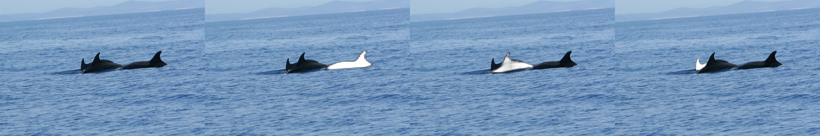

In [ ]:
#skip

# pick one image from the test set
img, _ = data_loader_test.dataset[0]
    
show_prediction(model, img)

We can also show predictions for the whole or for a subset of the dataset from a dataloader object:

In [ ]:
#export

def show_predictions(
    model,
    *,
    data_loader=None,
    dataset=None,
    n=None,
    score_threshold=0.5,
    iou_df=None,
    width=820
):
    """ Show at most `n` predictions for examples in a given data loader.
    """
    assert (data_loader is None) ^ (dataset is None), f"only one of dataloader ({dataloader}) and dataset({dataset}) must be defined"
    
    if data_loader:
        dataset = data_loader.dataset
        
    if n == None:
        n = len(dataset)
    else:
        n = min(n, len(dataset))

    for i in range(n):
        if iou_df is not None:
            print(f"IOU metric: {iou_df['iou'].iloc[i]}")
        show_prediction(model, img=dataset[i][0], score_threshold=score_threshold, width=width)

Shows predictions for the first two elements in the data loader:

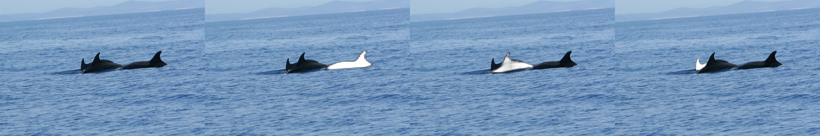

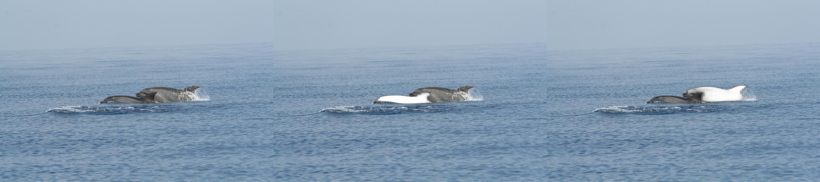

In [ ]:
#skip

show_predictions(model, data_loader=data_loader_test, n=2, score_threshold=0.5)

## Metrics

In [ ]:
#exporti

def get_true_and_predicted_masks(
    model: torchvision.models.detection.mask_rcnn.MaskRCNN,
    example: Tuple[torch.Tensor, Dict[str, torch.Tensor]],
    score_threshold: float = 0.5,
) -> Tuple[PIL.Image.Image, Dict[str, np.array]]:
    """ Returns a PIL image and dictionary containing both true and predicted masks as numpy arrays.
    """
    
    img = example[0]

    true_masks = (
        example[1]["masks"].mul(255).cpu().numpy().astype(np.int8)
    )

    model.eval()
    with torch.no_grad():
        predictions = model([img.to(device)])

    pred_scores = predictions[0]["scores"].cpu().numpy()

    pred_masks = predictions[0]["masks"].squeeze(1).mul(255).cpu().numpy().astype(np.int8)
    pred_masks = np.squeeze(pred_masks[np.argwhere(pred_scores >= score_threshold), :, :], 1)

    return ToPILImage()(img), {"true": true_masks, "predicted": pred_masks}

We have 3 dolphins on the photo, total of 3 are predicted with score higher than 0.5


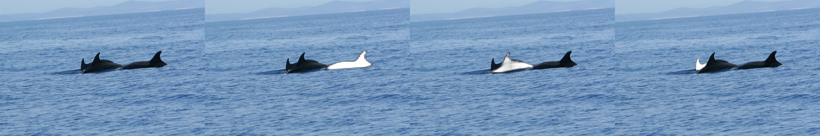

In [ ]:
#skip

_, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[0], 0.5)
img, _ = data_loader_test.dataset[0]

print(f'We have {masks["true"].shape[0]} dolphins on the photo, total of {masks["predicted"].shape[0]} are predicted with score higher than 0.5')

assert len(masks["true"].shape) == 3
assert len(masks["predicted"].shape) == 3

show_prediction(model, img)

### Metric explanation

For evaluating instance segmentation results, we would be using a metric called `Intersection over Union` or `IoU`. 
The IoU metric is a method to quantify the percent overlap between the ground-truth (or target) mask and the predicted (output) mask.  i. e., the IoU metric measures the number of pixels common between the ground-truth and prediction masks divided by the total number of pixels present across both masks and is mathematically represented as:


$$IoU = \frac{{target \cap prediction}}{{target \cup prediction}}$$


As a visual example, let's suppose we're tasked with calculating the IoU score of a prediction mask (colored yellow), given the ground truth labeled mask (colored blue). The intersection (A∩B) is comprised of the pixels found in both the prediction mask and the ground truth mask (denoted in green color), whereas the union (A∪B) is simply comprised of all pixels found in either the prediction or target mask.

![images/Iou_example1.jpg](images/Iou_example1.jpg) 
Image credits:  [link](https://towardsdatascience.com/intersection-over-union-iou-calculation-for-evaluating-an-image-segmentation-model-8b22e2e84686)

As can be seen from the above example, more the intersection or overlap between the ground truth and the predicted mask, greater is the IoU metric value. The maximum IoU metric value of 1 is obtained when both the predicted mask and ground-truth mask overlap perfectly and the minimum value of 0 is obtained when there is absolutely no overlap.



In [ ]:
#export

def iou_metric_mask_pair(
    binary_segmentation: np.array,
    binary_gt_label: np.array,
) -> float:
    """
    Compute the IOU between two binary segmentation (typically one ground truth and a predicted one).
    Input:
        binary_segmentation: binary 2D numpy array representing the region of interest as segmented by the algorithm
        binary_gt_label: binary 2D numpy array representing the region of interest as provided in the database
    Output:
        IOU: IOU between the segmentation and the ground truth
    """

    assert binary_segmentation.dtype in [np.int, np.int8, np.int16, np.int32, np.bool]
    assert binary_gt_label.dtype in [np.int, np.int8, np.int16, np.int32, np.bool]
    assert len(binary_segmentation.shape) == 2
    assert len(binary_gt_label.shape) == 2

    # turn all variables to booleans, just in case
    binary_segmentation = np.asarray(binary_segmentation, dtype=np.bool)
    binary_gt_label = np.asarray(binary_gt_label, dtype=np.bool)

    # compute the intersection
    intersection = np.logical_and(binary_segmentation, binary_gt_label)
    union = np.logical_or(binary_segmentation, binary_gt_label)

    # count the number of True pixels in the binary segmentation
    segmentation_pixels = float(np.sum(binary_segmentation.flatten()))

    # same for the ground truth
    gt_label_pixels = float(np.sum(binary_gt_label.flatten()))

    # same for the intersection and union
    intersection = float(np.sum(intersection.flatten()))
    union = float(np.sum(union.flatten()))

    # compute the Dice coefficient
    smooth = 0.001
    iou = (intersection + smooth) / (union + smooth)

    return iou

The above explanation is for a pair of single ground-truth or true mask and single predicted mask. 
Intersection over union metrics (IOU) for a pair of true and predicted masks can be calculated as follows:

In [ ]:
#skip

img, masks = get_true_and_predicted_masks(model, data_loader_test.dataset[0])

# calculate the metrics
iou_metric_mask_pair(
    binary_segmentation=masks["predicted"][0, :, :],
    binary_gt_label=masks["true"][0, :, :],
)

0.009040863480619882

In the instance segmentation task, a single image might predict multiple instance segmentation masks and the output prediction masks might not necessarily be in the same order as the ground-truth masks, i.e., the ordering of true and predicted masks can be and usually is different. In the example bellow, we have three true or ground truth masks but four predicted masks with score larger than 0.5:

In [ ]:
# export


def iou_metric_matrix_of_example(
    model: torchvision.models.detection.mask_rcnn.MaskRCNN,
    example: Tuple[torch.Tensor, Dict[str, torch.Tensor]],
    score_threshold: float = 0.5
) -> List[List[float]]:
    _, masks = get_true_and_predicted_masks(model, example, score_threshold)

    return np.array(
        [
            [
                iou_metric_mask_pair(
                    binary_segmentation=masks["predicted"][j, :, :],
                    binary_gt_label=masks["true"][i, :, :],
                )
                for i in range(masks["true"].shape[0])
            ]
            for j in range(masks["predicted"].shape[0])
        ]
    )

In [ ]:
#skip

metrics = iou_metric_matrix_of_example(model, data_loader_test.dataset[0], 0.5)

cm = sns.light_palette("lightblue", as_cmap=True)

df = pd.DataFrame(metrics)
df.style.background_gradient(cmap=cm)

For a single input image, which contains multiple prediction masks and ground-truth masks (since there can be more than one dophin in the image), we first calculate the IOU metric for all the predicted and gound-truth pairs .

In the example above, we have three dolphins with three true masks, while the model predicted four masks. This is why the matrix above has four rows (corresponding to predictions) and three columns (corresponding to ground truth). The first mask predicted by the model is represented by the first row (row 0). As we can see, the best fitting is with the third true mask (column 2). The second predicted mask is represented with the second row (row 1) and the best fit is with the first true mask (column 1) and so on. The last row is an extra prediction.

Thus for a single input image, we calculate the IOU metric in such a way that the total IOU score for the image is maximized. That is, in the above example the IOU metric for the first predicted mask is taken as 0.691147 and 0.586046, 0.514863, 0.000 for the second, third and fourth respectively and take the mean of the four IOU metric values to obtain the IOU metric for single example image. The last one is an extra incorrect prediction and hence it is assigned the value of 0.000.

We repeat the above for all the images in the dataset and take the mean of the IOU values to obtain the IOU metric value for the entire dataset

In [ ]:
#exporti

def _argmax2d(xs: np.array) -> Tuple[int, int]:
    assert len(xs.shape) == 2
    
    n_col = xs.shape[1]
    ij = xs.argmax()
    i = ij // n_col
    j = ij % n_col
    return i, j

def _drop_max_row_and_column(xs: np.array) -> Tuple[float, np.array]:
    i, j = _argmax2d(xs)
    
    max_value = xs[i, j]

    xs = np.delete(xs, i, 0)
    xs = np.delete(xs, j, 1)

    return max_value, xs

In [ ]:
#exporti

def _resize_to_square(xs: np.array) -> np.array:
    new_size = max(xs.shape)
    new_xs = np.zeros((new_size, new_size))
    new_xs[:xs.shape[0], :xs.shape[1]] = xs
    return new_xs

In [ ]:
#hide

a = np.arange(6).reshape((3, 2))
b = np.arange(6).reshape((2, 3))

actual = _resize_to_square(a)
expected = [[0, 1, 0], [2, 3, 0], [4, 5, 0]]
np.testing.assert_array_equal(actual, expected)

actual = _resize_to_square(b)
expected = [[0, 1, 2], [3, 4, 5], [0, 0, 0]]
np.testing.assert_array_equal(actual, expected)
np.testing.assert_array_equal(actual, expected)

In [ ]:
#export

def largest_values_in_row_colums(xs: np.array) -> List[float]:
    """ Approximates the largest value in each row/column.
    """
    if xs.shape == (0, ):
        return [0]
    
    assert len(xs.shape) == 2

    # resize matrix to square dimensions if needed
    if xs.shape[0] != xs.shape[1]:
        xs = _resize_to_square(xs)

    assert xs.shape[0] == xs.shape[1]
    
    
    # return the only value if a single value in the matrix
    if xs.shape[0] == 1:
        return [xs[0, 0]]

    # find the largest value in the matirx and recursively find the largest values in the remaining matrix
    max_value, remainder = _drop_max_row_and_column(xs)
    return [max_value] + largest_values_in_row_colums(remainder)

In [ ]:
# skip
largest_values_in_row_colums(metrics)

[0.6999534555127418, 0.6095453855961998, 0.531034752278878]

In [ ]:
# export


def iou_metric_example(
    model: torchvision.models.detection.mask_rcnn.MaskRCNN,
    example: Tuple[torch.Tensor, Dict[str, torch.Tensor]],
    score_threshold: float = 0.5,
) -> float:

    iou_matrix = iou_metric_matrix_of_example(model, example, score_threshold)
    matching_ious = largest_values_in_row_colums(iou_matrix)
    iou = np.mean(matching_ious)

    return iou

Finally, we can get IOU metrics for the whole image:

In [ ]:
# skip

metric = iou_metric_example(model, data_loader_test.dataset[4], 0.5)

print(f"Average IOU metric on given example is {metric:.3f}")

Average IOU metric on given example is 0.300


In [ ]:
# export


def iou_metric(
    model: torchvision.models.detection.mask_rcnn.MaskRCNN,
    dataset: torch.utils.data.Dataset,
    score_threshold: float = 0.5,
) -> float:
    """Calculate IOU metric on the whole dataloader"""

    iou = [
        iou_metric_example(model, dataset[i], score_threshold)
        for i in range(len(dataset))
    ]
    
    img_paths = [f for f in dataset.img_paths]
    
    iou_df = pd.DataFrame(dict(paths=img_paths, iou=iou)).sort_values(by="iou")
    
    iou = np.mean(iou)
        
    return iou, iou_df

In [ ]:
#skip

iou, iou_df = iou_metric(model, data_loader_test.dataset)

iou_df.sort_values(by="iou").style.background_gradient(cmap=cm)

CPU times: user 10.1 s, sys: 7.85 ms, total: 10.1 s
Wall time: 6.59 s


In [ ]:
# exporti

class PermutedDataset():
    def __init__(self, ds, permutation):
        self.ds = ds
        self.permutation = permutation
        
    def __getitem__(self, idx):
        return self.ds[self.permutation[idx]]
    
    def __len__(self):
        return len(self.permutation)

In [ ]:
# export

def show_predictions_sorted_by_iou(model, dataset):
    iou, iou_df = iou_metric(model, dataset)

    permutation = iou_df.index.to_list()

    sorted_dataset = PermutedDataset(dataset, permutation)

    show_predictions(model, dataset=sorted_dataset, iou_df=iou_df)

IOU metric: 0.21713649373748173


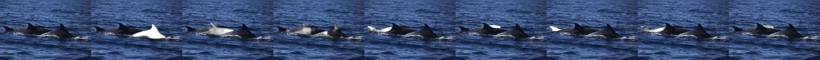

IOU metric: 0.23516181851988224


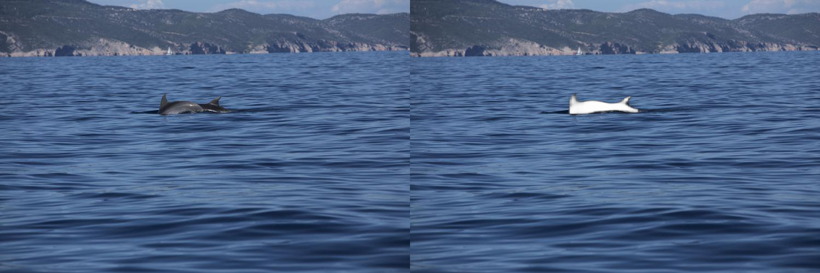

IOU metric: 0.23886763657815555


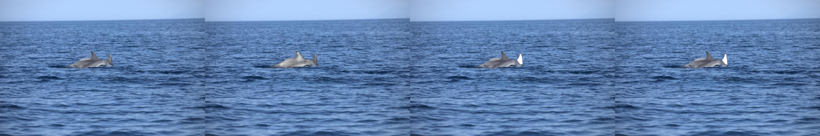

IOU metric: 0.2485782288414421


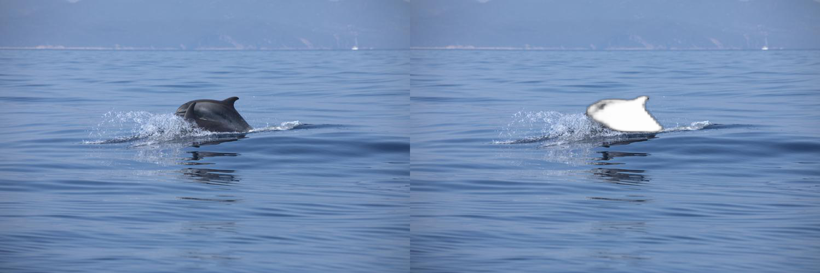

IOU metric: 0.2937505354547715


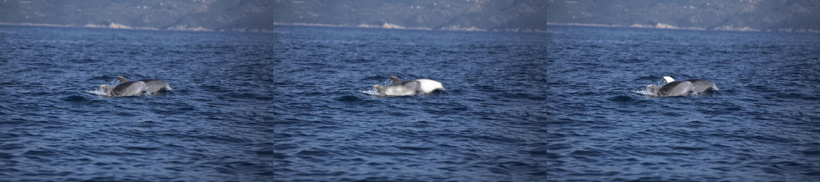

IOU metric: 0.3004759731504556


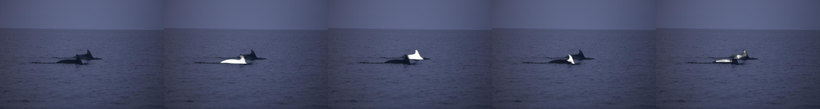

IOU metric: 0.30172758091455804


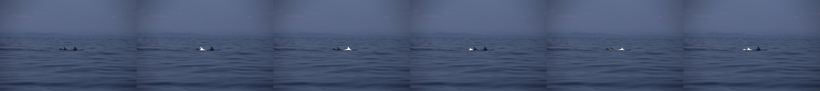

IOU metric: 0.3030829051738324


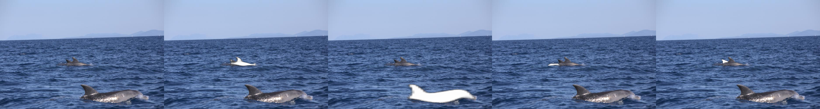

IOU metric: 0.3086630906471554


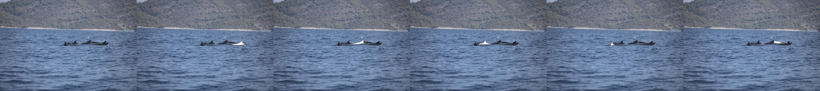

IOU metric: 0.32846524541442307


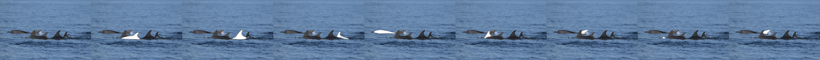

IOU metric: 0.3361396219757273


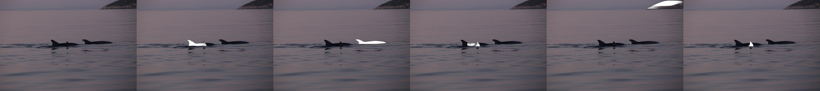

IOU metric: 0.3364484265521705


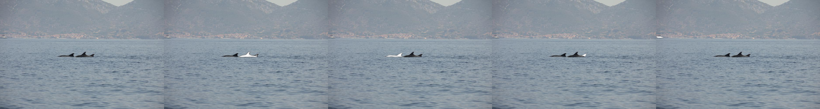

IOU metric: 0.3428030754274021


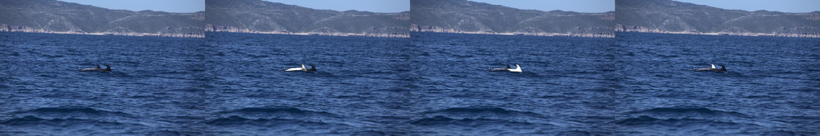

IOU metric: 0.36157219663660756


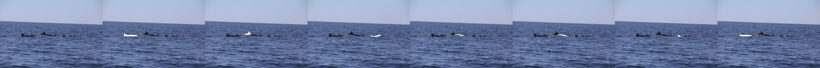

IOU metric: 0.3652433124089978


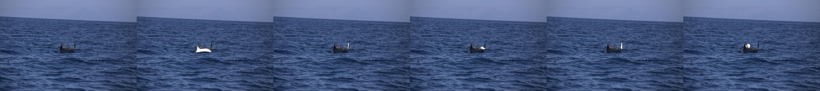

IOU metric: 0.3676078045693399


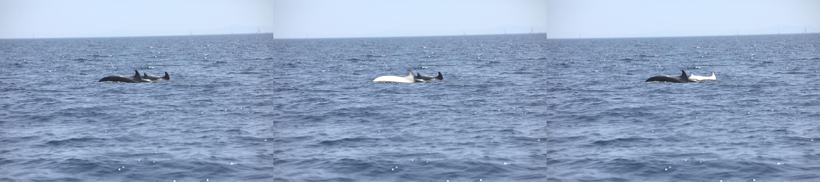

IOU metric: 0.421963996738445


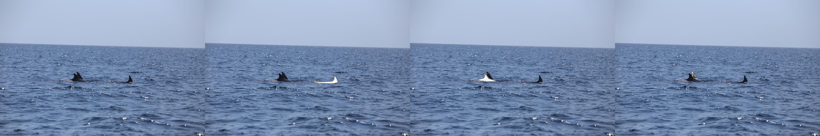

IOU metric: 0.42277124387024406


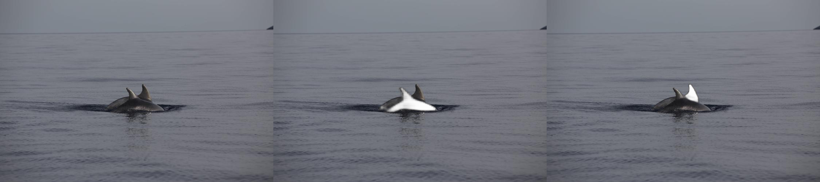

IOU metric: 0.430506443127559


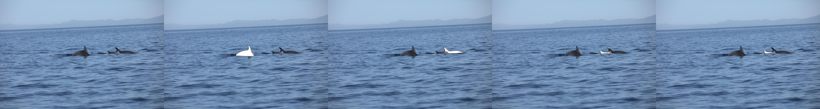

IOU metric: 0.44508573144544766


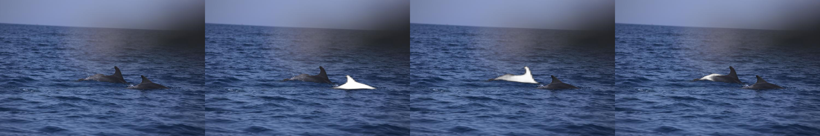

IOU metric: 0.44649887084427164


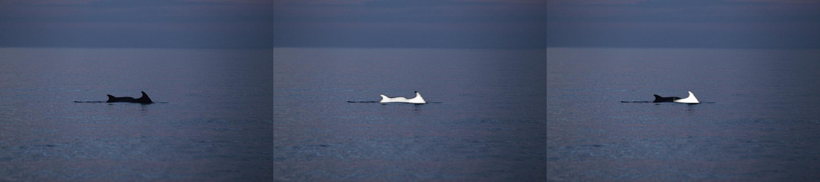

IOU metric: 0.4472671935895272


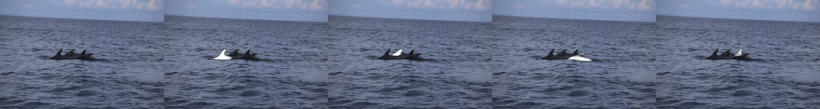

IOU metric: 0.46577921887805673


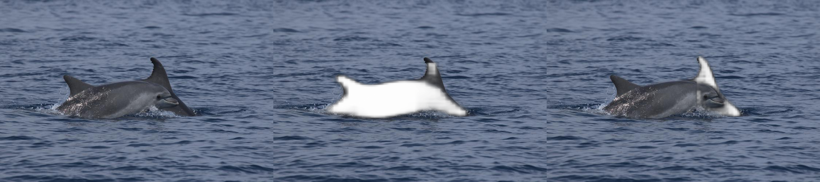

IOU metric: 0.4694702871921999


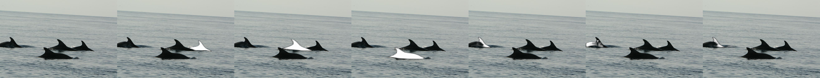

IOU metric: 0.47475510664957055


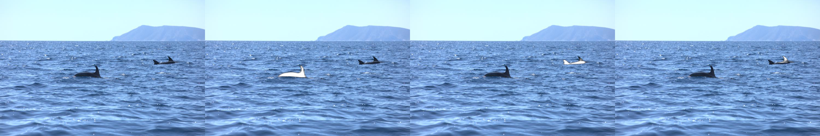

IOU metric: 0.5071124683565756


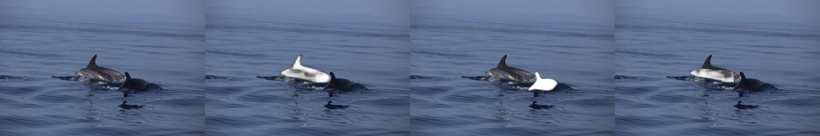

IOU metric: 0.544885413653808


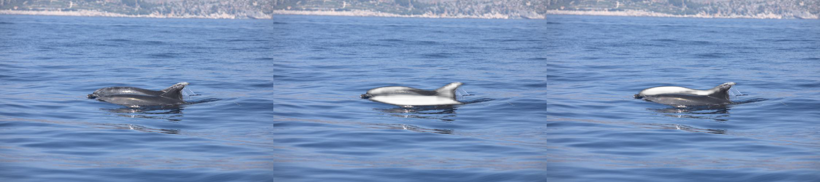

IOU metric: 0.5626076687301744


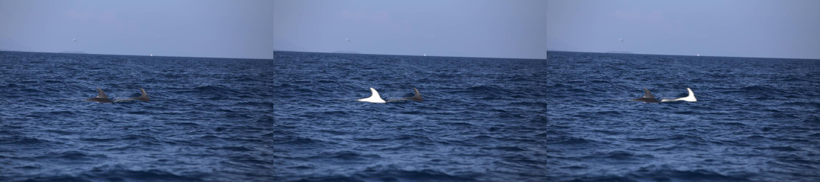

IOU metric: 0.6039026900161608


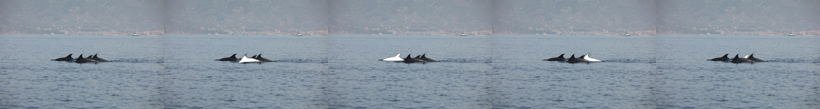

IOU metric: 0.6135111977959399


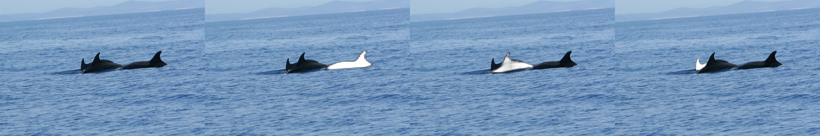

IOU metric: 0.6159746130297648


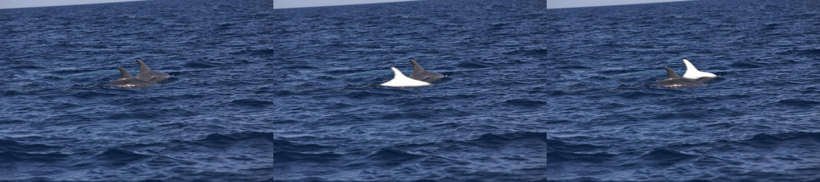

IOU metric: 0.6171491240732716


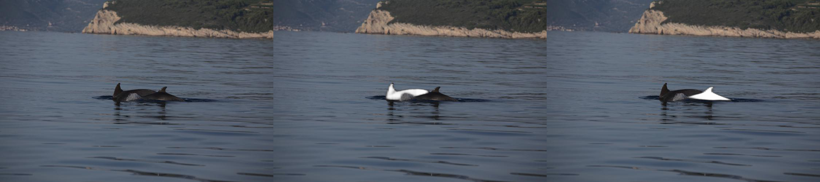

IOU metric: 0.632938069917827


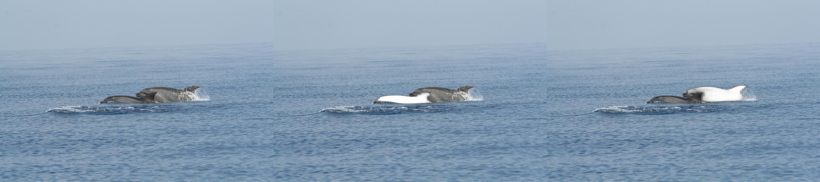

IOU metric: 0.6400163390210463


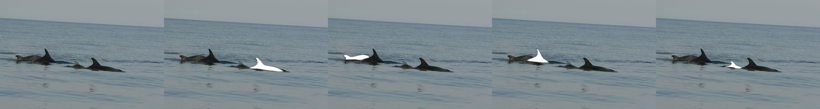

IOU metric: 0.647769649705985


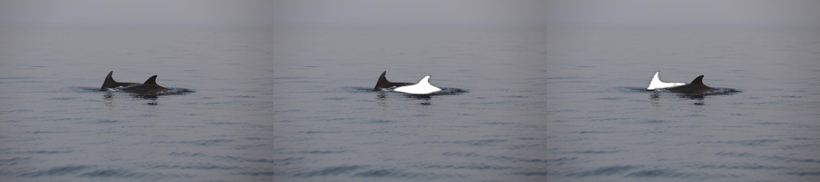

IOU metric: 0.6615849240495006


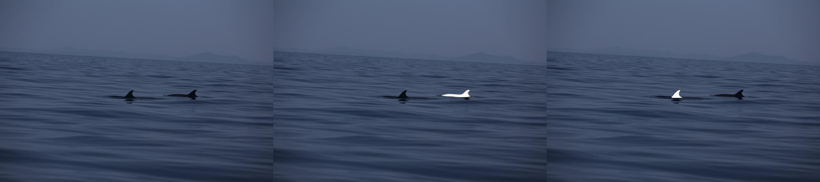

IOU metric: 0.6784650432524649


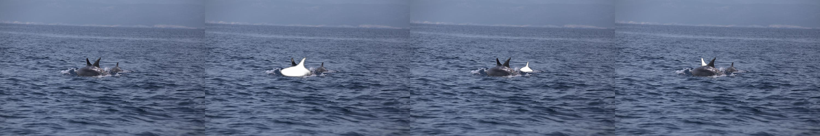

IOU metric: 0.6868002346413177


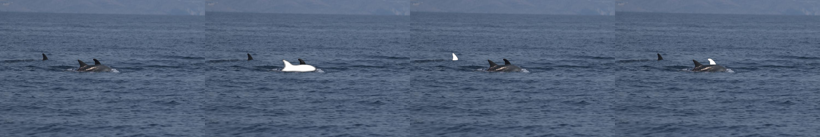

IOU metric: 0.7543693223608632


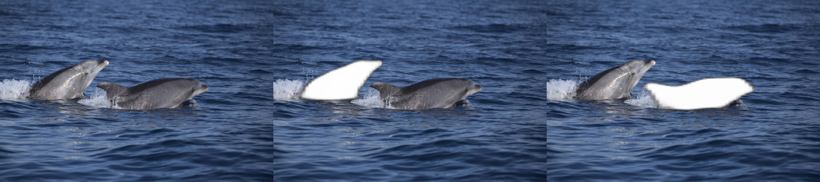

In [ ]:
# skip

show_predictions_sorted_by_iou(model, data_loader_test.dataset)